In [1]:
from pathlib import Path
from typing import Optional

import janitor
import pandas as pd
import plotnine as gg
import seaborn as sns

%config InlineBackend.figure_format='retina'

In [2]:
benchmark_dir = Path("../benchmarks/")
assert benchmark_dir.exists()
assert benchmark_dir.is_dir()

## Data Processing

Organization of benchmarks directory:

1. pipeline
2. rules
3. individual runs

> I may want to add more information to the name of the rules to keep them separate and not overwritten.
> For instance, including the date would be useful or metadata such as the data size for SBC or debug status for the fitting pipeline.

In [3]:
list(benchmark_dir.iterdir())

[PosixPath('../benchmarks/010_010_run-crc-sampling-snakemake'),
 PosixPath('../benchmarks/012_010_simulation-based-calibration-snakemake')]

In [4]:
def process_benchmark_file(bench_f: Path) -> pd.DataFrame:
    return pd.read_csv(bench_f, sep="\t").assign(
        step=bench_f.name.replace(bench_f.suffix, "")
    )


def get_benchmark_data_for_rule_dir(
    rule_d: Path, pipeline_name: str
) -> Optional[pd.DataFrame]:
    bench_dfs: list[pd.DataFrame] = [
        process_benchmark_file(b) for b in rule_d.iterdir()
    ]
    if len(bench_dfs) == 0:
        return None

    return (
        pd.concat(bench_dfs)
        .assign(rule=rule_d.name, pipeline=pipeline_name)
        .clean_names()
    )


benchmark_df_list: list[pd.DataFrame] = []

for pipeline_dir in benchmark_dir.iterdir():
    for rule_dir in pipeline_dir.iterdir():
        df = get_benchmark_data_for_rule_dir(rule_dir, pipeline_name=pipeline_dir.name)
        if df is not None:
            benchmark_df_list.append(df)

benchmark_df = pd.concat(benchmark_df_list).reset_index(drop=True)
benchmark_df.head()

,s,h_m_s,max_rss,max_vms,max_uss,max_pss,io_in,io_out,mean_load,cpu_time,step,rule,pipeline
0,900.0916,0:15:00,11876.86,16598.31,2643.14,2643.29,8.54,144.07,80.96,138.08,sp2-default_MCMC_perm106,run_sbc,012_010_simulation-based-calibration-snakemake
1,681.0140,0:11:21,11834.54,16552.55,2673.76,2698.16,8.98,149.32,67.21,156.21,sp2-default_MCMC_perm447,run_sbc,012_010_simulation-based-calibration-snakemake
2,745.1272,0:12:25,12174.35,16889.28,2686.37,2686.53,15.43,160.75,82.28,131.27,sp2-default_MCMC_perm10,run_sbc,012_010_simulation-based-calibration-snakemake
3,609.5455,0:10:09,12045.56,16742.46,2615.14,2637.87,4.54,92.44,133.23,115.00,sp2-default_MCMC_perm82,run_sbc,012_010_simulation-based-calibration-snakemake
4,605.5162,0:10:05,11209.66,15945.14,2464.32,2477.39,8.06,84.99,79.81,119.25,sp2-default_MCMC_perm24,run_sbc,012_010_simulation-based-calibration-snakemake


## Data dictionary

| colname | type (unit) | description |
|-------- |-------------|-------------|
| s | float (seconds) | Running time in seconds. |
| h:m:s	| string (-) | Running time in hour, minutes, seconds format. |
| max_rss | float (MB) | Maximum "Resident Set Size”, this is the non-swapped physical memory a process has used. |
| max_vms | float (MB) | Maximum “Virtual Memory Size”, this is the total amount of virtual memory used by the process. |
| max_uss | float (MB) | “Unique Set Size”, this is the memory which is unique to a process and which would be freed if the process was terminated right now. |
| max_pss | float (MB) | “Proportional Set Size”, is the amount of memory shared with other processes, accounted in a way that the amount is divided evenly between the processes that share it (Linux only). |
| io_in | float (MB) | The number of MB read (cumulative). |
| io_out | float (MB) | The number of MB written (cumulative). |
| mean_load | float (-) | CPU usage over time, divided by the total running time (first row). |
| cpu_time | float (-) | CPU time summed for user and system. |

## Data analysis and visualization

In [5]:
benchmark_df.groupby(["pipeline", "rule"]).mean().round(2)

s  \
pipeline                                       rule                        
012_010_simulation-based-calibration-snakemake collate_sbc        272.46   
                                               generate_mockdata    8.94   
                                               run_sbc            655.81   

                                                                   max_rss  \
pipeline                                       rule                          
012_010_simulation-based-calibration-snakemake collate_sbc          288.61   
                                               generate_mockdata    216.96   
                                               run_sbc            11195.34   

                                                                   max_vms  \
pipeline                                       rule                          
012_010_simulation-based-calibration-snakemake collate_sbc         1013.56   
                                               generate_mockdata    929.21   
                                               run_sbc            15717.18   

                                                                  max_uss  \
pipeline                                       rule                         
012_010_simulation-based-calibration-snakemake collate_sbc         286.13   
                                               generate_mockdata   214.40   
                                               run_sbc            2582.34   

                                                                  max_pss  \
pipeline                                       rule                         
012_010_simulation-based-calibration-snakemake collate_sbc         286.20   
                                               generate_mockdata   214.44   
                                               run_sbc            2592.93   

                                                                    io_in  \
pipeline                                       rule                         
012_010_simulation-based-calibration-snakemake collate_sbc        2269.80   
                                               generate_mockdata   259.24   
                                               run_sbc             244.20   

                                                                  io_out  \
pipeline                                       rule                        
012_010_simulation-based-calibration-snakemake collate_sbc          0.22   
                                               generate_mockdata    0.29   
                                               run_sbc            122.06   

                                                                  mean_load  \
pipeline                                       rule                           
012_010_simulation-based-calibration-snakemake collate_sbc            35.53   
                                               generate_mockdata      40.41   
                                               run_sbc               114.10   

                                                                  cpu_time  
pipeline                                       rule                         
012_010_simulation-based-calibration-snakemake collate_sbc           95.78  
                                               generate_mockdata      3.72  
                                               run_sbc              128.91

In [6]:
benchmark_df_long = benchmark_df[
    ["pipeline", "rule", "step", "cpu_time", "max_rss", "mean_load", "cpu_time"]
].pivot_longer(["pipeline", "rule", "step"])

benchmark_df_long.head()

,pipeline,rule,step,variable,value
0,012_010_simulation-based-calibration-snakemake,run_sbc,sp2-default_MCMC_perm106,cpu_time,138.08
1,012_010_simulation-based-calibration-snakemake,run_sbc,sp2-default_MCMC_perm447,cpu_time,156.21
2,012_010_simulation-based-calibration-snakemake,run_sbc,sp2-default_MCMC_perm10,cpu_time,131.27
3,012_010_simulation-based-calibration-snakemake,run_sbc,sp2-default_MCMC_perm82,cpu_time,115.00
4,012_010_simulation-based-calibration-snakemake,run_sbc,sp2-default_MCMC_perm24,cpu_time,119.25


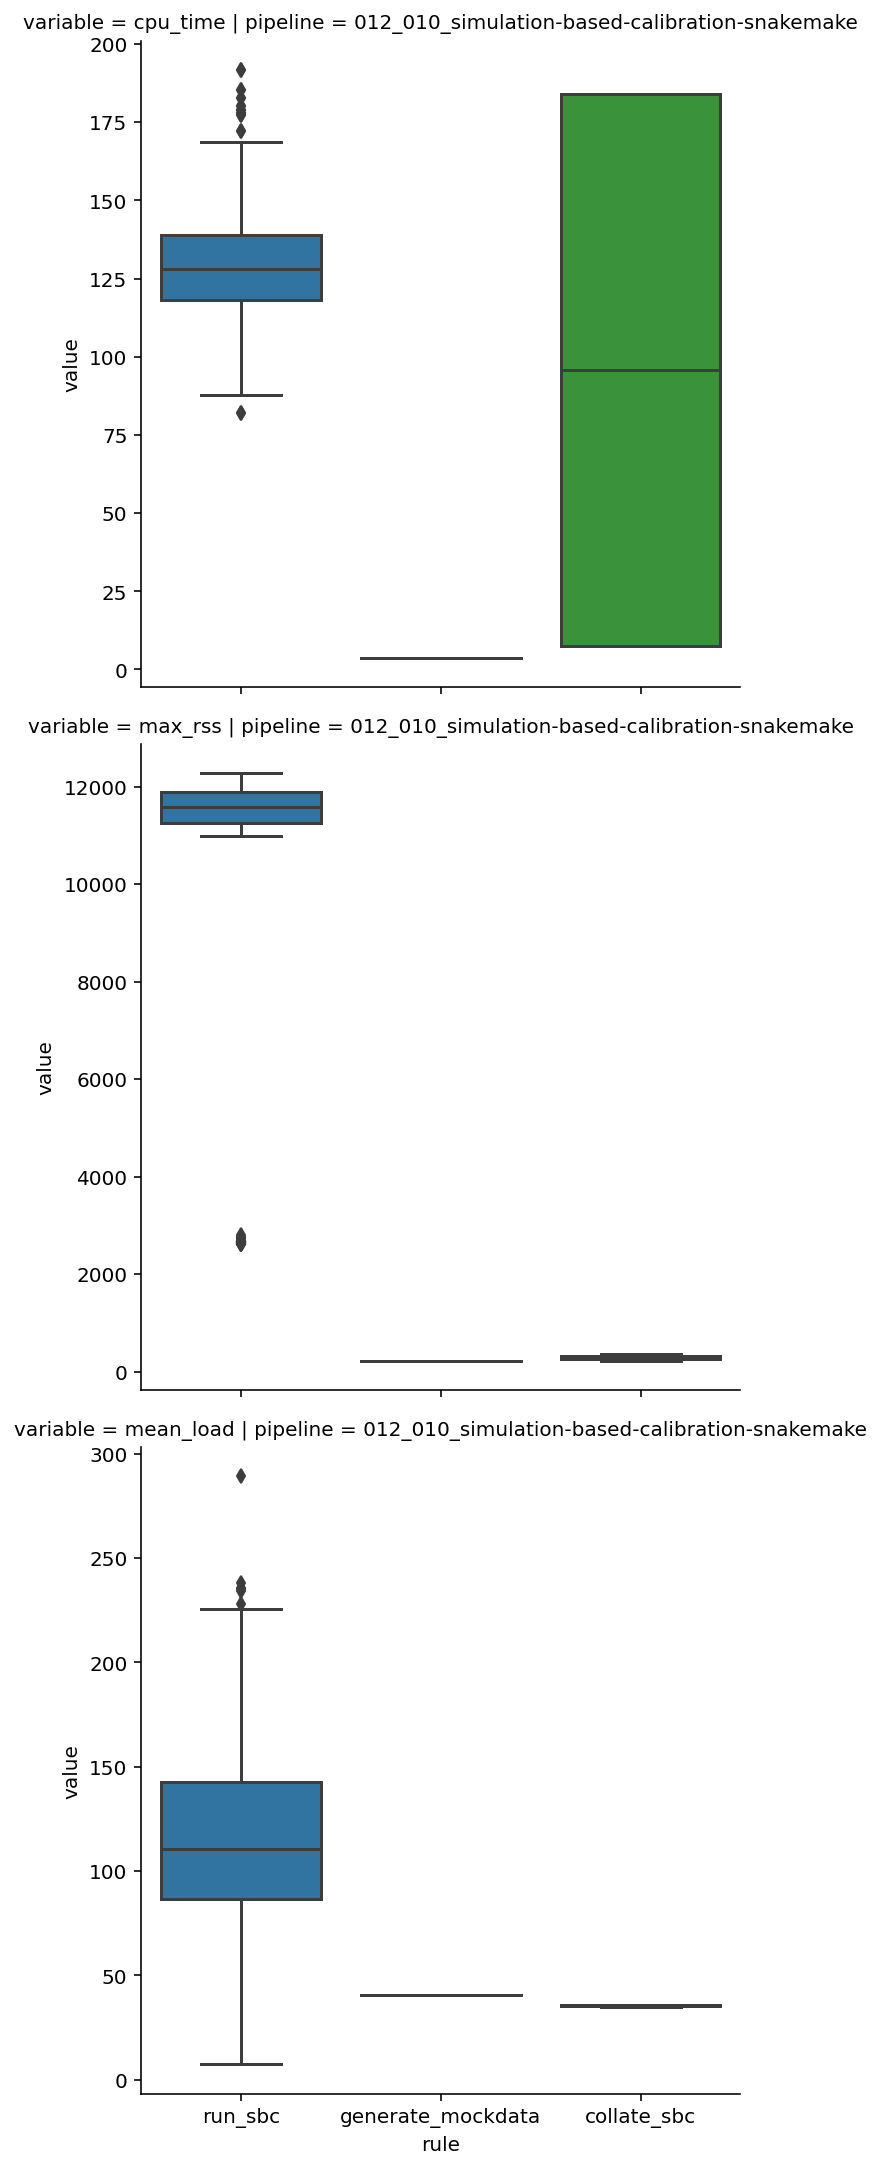

In [7]:
sns.catplot(
    data=benchmark_df_long,
    x="rule",
    y="value",
    kind="box",
    row="variable",
    col="pipeline",
    sharey=False,
);

---

In [8]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-07-26

Python implementation: CPython
Python version       : 3.9.2
IPython version      : 7.21.0

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 3.10.0-1062.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit

Hostname: compute-a-17-126.o2.rc.hms.harvard.edu

Git branch: sbc-uniform-check

seaborn : 0.11.1
pandas  : 1.2.3
janitor : 0.20.14
plotnine: 0.7.1

